<a href="https://colab.research.google.com/github/hananbahtiti/Hybrid-Intrusion-detection-Systems/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download Dataset

In [ ]:
!wget -O NGIDS-DS.rar https://unsworks.unsw.edu.au/bitstreams/0ac2820a-5131-43ab-90b2-c624c8d73649/download

--2025-04-26 08:47:38--  https://unsworks.unsw.edu.au/bitstreams/0ac2820a-5131-43ab-90b2-c624c8d73649/download
Resolving unsworks.unsw.edu.au (unsworks.unsw.edu.au)... 54.253.215.118
Connecting to unsworks.unsw.edu.au (unsworks.unsw.edu.au)|54.253.215.118|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://unsworks.unsw.edu.au/server/api/core/bitstreams/0ac2820a-5131-43ab-90b2-c624c8d73649/content [following]
--2025-04-26 08:47:40--  https://unsworks.unsw.edu.au/server/api/core/bitstreams/0ac2820a-5131-43ab-90b2-c624c8d73649/content
Reusing existing connection to unsworks.unsw.edu.au:443.
HTTP request sent, awaiting response... 200 200
Length: unspecified [application/x-rar-compressed]
Saving to: ‘NGIDS-DS.rar’

NGIDS-DS.rar            [                <=> ] 941.51M  17.3MB/s    in 56s     

2025-04-26 08:48:36 (16.8 MB/s) - ‘NGIDS-DS.rar’ saved [987249484]



In [ ]:
!unrar x /content/NGIDS-DS.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/NGIDS-DS.rar

Creating    NGIDS                                                     OK
Creating    NGIDS/NGIDS-DS-v1                                         OK
Extracting  NGIDS/NGIDS-DS-v1/feature_descr.csv                            0%  OK 
Extracting  NGIDS/NGIDS-DS-v1/ground_truth.csv                             0%  OK 
Creating    NGIDS/NGIDS-DS-v1/host logs                               OK
Extracting  NGIDS/NGIDS-DS-v1/host logs/1.csv                              0%  OK 
Extracting  NGIDS/NGIDS-DS-v1/host logs/10.csv                             0%  1%  OK 
Extracting  NGIDS/NGIDS-DS-v1/host logs/11.csv                             1%  OK 
Extracting  NGIDS/NGIDS-DS-v1/host logs/12.csv                             1%  2%  OK 
Extracting  NGIDS/NGIDS-DS-v1/host logs/13.csv                             2%  OK 
Extrac

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Host data processing

In [ ]:
!pip install tqdm

In [ ]:
!rm -rf /content/NGIDS

In [2]:
import pandas as pd
import numpy as np
import os
import glob
import math
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

import time
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

import cudf
import dask_cudf
from dask_cuda import LocalCUDACluster
from dask.distributed import Client


/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


In [ ]:
!cp /content/final_del.csv /content/drive/MyDrive/hybrid_IDS/dataset/all/

In [ ]:
!cp /content/fainal_nan_2.csv /content/drive/MyDrive/hybrid_IDS/dataset/all/

In [ ]:

filename = '/content/final_del_converted.csv'

count = 0
with open(filename, 'r') as f:
    for line in f:
        count += 1

print(f"عدد الأسطر (مع الهيدر) = {count}")
print(f"عدد البيانات (بدون الهيدر) = {count - 1}")

عدد الأسطر (مع الهيدر) = 90054239
عدد البيانات (بدون الهيدر) = 90054238


In [ ]:
class HostPreprocessing():
  def __init__(self):
    pass

  def __file_path_collection(self, folder_path, ends='.csv'):
    try:
      joined_list = []
      for file_name in os.listdir(folder_path):
        file_name = os.path.join(folder_path, file_name)
        if os.path.isfile(file_name) and file_name.endswith(ends):
          joined_list.append(file_name)
      return joined_list

    except Exception as e:
      return f"An error occurred: {e}"


  def rename_columns(self, folder_path):
    files = self.__file_path_collection(folder_path)
    try:
      for file in tqdm(files, desc="Renaming columns") :
        df = pd.read_csv(file)
        column_name = df.columns.tolist()
        df.rename(columns={
            column_name[0]:'Date',
            column_name[1]:'Time',
            column_name[2]:'Unique_Identification',
            column_name[3]:'Execution_Path',
            column_name[4]:'System_Calls_Identifiers',
            column_name[5]:"Event's_Unique_Identification",
            column_name[6]:'attacks',
            column_name[7]:"Sub_Type_Attack",
            column_name[8]:"Label"
            }, inplace=True)
        df.to_csv(file, index=False)
      return f"done files..."

    except Exception as e:
      return f"An error occurred: {e}"


  def data_encoding(self, folder_path, column_number : int):
    files = self.__file_path_collection(folder_path)
    encoder = LabelEncoder()
    all_value = []
    try:
      for file in tqdm(files, desc="Extract all values from files"):
        df = pd.read_csv(file)
        if column_number < df.shape[1]:
                all_value.extend(df.iloc[:, column_number].dropna().unique())

        else:
            print(f"❌ Skipped (no column {column_number}): {file}")

      print( f"number value: {len(all_value)}" )
      encoder.fit(all_value)

      for file in tqdm(files, desc="encoder data"):
        df = pd.read_csv(file)
        df.iloc[:, column_number] = encoder.transform(df.iloc[:, column_number])
        #df.drop(columns=[df.columns[column_number]], inplace=True)
        #print(len(df.iloc[:, column_number].dropna().unique()), df.iloc[:, column_number].dropna().unique(), file )
        df.to_csv(file, index=False)
      return f"done file..."

    except Exception as e:
      return f"An error occurred: {e}"








  def encode_execution_paths(folder_path: str, path_column: str = 'Execution_Path', encoding: str = 'utf-8'):
      """
      Encode execution paths in CSV files inside a folder by splitting the paths into parts.

      Args:
          folder_path (str): Path to the folder containing CSV files.
          path_column (str): Name of the column containing the paths. Default is 'Execution_Path'.
          encoding (str): Encoding of the CSV files. Default is 'utf-8'.
      """

      # Get all CSV filenames
      csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

      # Step 1: Build the dictionary and find maximum path depth
      unique_parts = set()
      max_depth = 0

      print("Step 1/2: Building the dictionary and detecting path depth...")
      for filename in tqdm(csv_files, desc="Building dictionary"):
          file_path = os.path.join(folder_path, filename)

          for chunk in pd.read_csv(file_path, usecols=[path_column], chunksize=10000, encoding=encoding):
              paths = chunk[path_column].dropna()
              for path in paths:
                  parts = str(path).split('/')
                  parts = [p for p in parts if p]
                  unique_parts.update(parts)
                  max_depth = max(max_depth, len(parts))

      # Create the encoder dictionary
      encoder = {part: idx for idx, part in enumerate(sorted(unique_parts))}

      print(f"Number of unique parts: {len(encoder)}")
      print(f"Maximum path depth: {max_depth}")

      # Step 2: Process each file and merge results
      print("\nStep 2/2: Processing files and merging results...")
      for filename in tqdm(csv_files, desc="Processing files"):
          file_path = os.path.join(folder_path, filename)
          new_chunks = []

          for chunk in pd.read_csv(file_path, chunksize=10000, encoding=encoding):
              if path_column not in chunk.columns:
                  continue

              encoded_columns = []

              for path in chunk[path_column].fillna(''):
                  parts = str(path).split('/')
                  parts = [p for p in parts if p]
                  encoded_parts = [encoder.get(part, np.nan) for part in parts]
                  while len(encoded_parts) < max_depth:
                      encoded_parts.append(np.nan)
                  encoded_columns.append(encoded_parts)

              # Convert encoded parts to DataFrame with improved column names
              encoded_df = pd.DataFrame(
                  encoded_columns,
                  columns=[f"{path_column}_part_{i}" for i in range(max_depth)]
              )

              # Merge original data with encoded data
              combined_chunk = pd.concat([chunk.reset_index(drop=True), encoded_df], axis=1)
              new_chunks.append(combined_chunk)

          # Merge all chunks
          final_df = pd.concat(new_chunks, ignore_index=True)

          # Save the final file
          new_file_path = os.path.join(folder_path, filename)
          final_df.to_csv(new_file_path, index=False, encoding=encoding)

      print("\n✅ Done! All files have been processed and saved successfully.")






  def extract_datetime_features(self, folder_path, date_col, time_col ):
    files = self.__file_path_collection(folder_path) # Assign the output of __file_path_collection to files
    try:
      for file in tqdm(files, desc="read all files"): # Iterate through the 'files' list, not 'file_paths'
        df = pd.read_csv(file) # Read each file into a DataFrame
        if date_col in df.columns and time_col in df.columns :
          df[date_col] = pd.to_datetime(df[date_col], format='%d/%m/%Y', errors='coerce', dayfirst=True)

          df['year'] = df[date_col].dt.year
          df['month'] = df[date_col].dt.month
          df['day'] = df[date_col].dt.day

          # Assuming 'Time' column is string and needs to be converted to datetime
          df[time_col] = pd.to_datetime(df[time_col], format='%H:%M:%S', errors='coerce', dayfirst=True)

          df['hour'] = df[time_col].dt.hour
          df['minute'] = df[time_col].dt.minute
          df['second'] = df[time_col].dt.second

          df.drop(columns=[date_col, time_col], inplace=True)

          df.to_csv(file, index=False) # Save changes back to the original file
          print(f"✅ Processed: {df.head(3)}")

    except Exception as e:
        print(f"❌ Error in {file}: {e}") # Print the error and the file name








  def file_collection(self, folder_path):
    try:
      file_paths = self.__file_path_collection(folder_path)
      if file_paths:
        output_folder = os.path.join(os.getcwd(),'files')
        os.makedirs(output_folder ,exist_ok=True)
        output_file = os.path.join(output_folder,"final.csv")

        for file in tqdm(file_paths, desc="read all files"):

          first = True
          chunk = pd.read_csv(file, chunksize=10000)
          for part in chunk:
            part.to_csv(output_file, mode='a', header=first, index=False)
            first = False

      return  f"done file..."

    except Exception as e:
      return f"An error occurred: {e}"



  def delete_columns(self, file_path, columns_names: list):
    try:
        # اقرأ الملف كدفعات
        chunks = pd.read_csv(file_path, chunksize=10000)

        # ملف مؤقت للحفظ
        temp_file_path = file_path.replace('.csv', '_temp.csv')

        first_chunk = True

        for chunk in chunks:
            # حذف الأعمدة المطلوبة إن وجدت
            chunk = chunk.drop(columns=[col for col in columns_names if col in chunk.columns], axis=1)

            # حفظ إلى الملف المؤقت
            chunk.to_csv(temp_file_path, mode='w' if first_chunk else 'a', header=first_chunk, index=False)
            first_chunk = False

        os.remove(file_path)
        os.rename(temp_file_path, file_path)  # إعادة تسمية الملف المؤقت

        return "✅ Columns deleted and file overwritten successfully!"

    except Exception as e:
        return f"❌ An error occurred: {e}"




  def old_smart_impute_and_save(self, input_file, output_file, chunk_size=1000000):
    """
    This method automatically fills missing values based on their missing ratio,
    then saves the cleaned data to a new CSV file.
    """
    try:
        start_time = time.time()  # Start timing ⏱️

        # Load the data
        chunks = pd.read_csv(input_file, chunksize=chunk_size)
        df = next(chunks)  # Read the first chunk

        # Define the target columns for imputation
        cols_to_impute = ['Execution_Path_part_2', 'Execution_Path_part_3', 'Execution_Path_part_4']

        # Build the feature set including helper columns
        features = df[['attacks', 'Sub_Type_Attack', 'Label', 'Execution_Path_part_1'] + cols_to_impute]

        # Calculate missing value ratios
        missing_ratio = features.isna().mean()
        print("📊 Missing value ratio per column:\n", missing_ratio)

        # Smart imputation based on missing value ratio
        for col in tqdm(cols_to_impute, desc="Imputing columns", unit="column"):  # Adding tqdm here for progress bar
            if col not in df.columns:
                continue  # Skip if the column was already dropped

            ratio = missing_ratio[col]
            print(f"\n=== Processing column: {col} (Missing {ratio:.2%}) ===")

            if ratio > 0.95:
                print(f"⚠️  Column {col} has too many missing values (>80%). Dropping it...")
                df.drop(columns=[col], inplace=True)

            elif ratio < 0.3:
                print(f"🛠️  Using Iterative Imputer for {col}...")
                imputer = IterativeImputer(max_iter=10, random_state=0)
                temp_data = features[['attacks', 'Sub_Type_Attack', 'Label', 'Execution_Path_part_1', col]]

                # Wrap the imputation in tqdm to show the progress per iteration
                for i in tqdm(range(imputer.max_iter), desc=f"Iterating {col}", leave=False, unit="iteration"):
                    imputed_data = imputer.fit_transform(temp_data)
                df[col] = imputed_data[:, -1]

            else:
                print(f"🔍 Using KNN Imputer for {col}...")
                imputer = KNNImputer(n_neighbors=5)
                temp_data = features[['attacks', 'Sub_Type_Attack', 'Label', 'Execution_Path_part_1', col]]

                # KNN imputation is done in one step, so we don't need a loop for iterations
                imputed_data = imputer.fit_transform(temp_data)
                df[col] = imputed_data[:, -1]

        # Save the cleaned data
        df.to_csv(output_file, index=False)
        print(f"\n✅ Successfully completed missing value filling and saved to {output_file}.")

        end_time = time.time()  # End timing ⏱️
        elapsed_time = end_time - start_time
        print(f"⏱️ Total execution time: {elapsed_time:.2f} seconds")

        return df

    except Exception as e:
        return f"❌ An error occurred: {e}"










  def create_balanced_sample_with_progress(self, input_file, output_file,
                                          column_name, value_0, value_1,
                                          total_rows, chunksize=100_000):
      """
      إنشاء ملف CSV متوازن بين فئتين باستخدام tqdm لعرض التقدم.

      Args:
          input_file (str): مسار ملف CSV الأصلي.
          output_file (str): مسار الحفظ للملف الجديد.
          column_name (str): اسم العمود الذي يحتوي على الفئة (مثل 'Label').
          value_0 (int): قيمة الفئة الأولى (مثل 0).
          value_1 (int): قيمة الفئة الثانية (مثل 1).
          total_rows (int): عدد الصفوف المطلوب في الملف النهائي.
          chunksize (int): عدد الصفوف التي تُقرأ في كل تكرار.
      """
      try:
          half_rows = total_rows // 2
          zeros_collected, ones_collected = 0, 0
          zeros, ones = [], []

          # حساب عدد الصفوف الكلي (بدون الهيدر)
          with open(input_file) as f:
              total_lines = sum(1 for _ in f) - 1

          with tqdm(total=total_lines, desc="📦 Collecting balanced samples", ncols=100) as pbar:
              for chunk in pd.read_csv(input_file, chunksize=chunksize):
                  zero_chunk = chunk[chunk[column_name] == value_0]
                  one_chunk = chunk[chunk[column_name] == value_1]

                  if zeros_collected < half_rows and not zero_chunk.empty:
                      needed = half_rows - zeros_collected
                      selected = zero_chunk.head(needed)
                      zeros.append(selected)
                      zeros_collected += len(selected)

                  if ones_collected < half_rows and not one_chunk.empty:
                      needed = half_rows - ones_collected
                      selected = one_chunk.head(needed)
                      ones.append(selected)
                      ones_collected += len(selected)

                  pbar.update(len(chunk))

                  if zeros_collected >= half_rows and ones_collected >= half_rows:
                      break

          # التحقق إذا تم جمع ما يكفي من الصفوف
          if zeros_collected < half_rows or ones_collected < half_rows:
              print(f"⚠️ لم يتم جمع الكمية المطلوبة: 0s={zeros_collected}, 1s={ones_collected}")
              min_rows = min(zeros_collected, ones_collected)
              print(f"🔄 سيتم إنشاء الملف باستخدام {min_rows * 2} صف فقط.")
              result = pd.concat([
                  pd.concat(zeros, ignore_index=True).head(min_rows),
                  pd.concat(ones, ignore_index=True).head(min_rows)
              ])
          else:
              result = pd.concat(zeros + ones, ignore_index=True)

          result = result.sample(frac=1).reset_index(drop=True)
          result.to_csv(output_file, index=False)

          print(f"✅ File saved to: {output_file} — total rows: {len(result)}")

      except Exception as e:
          print(f"❌ An error occurred: {e}")



a = HostPreprocessing()
#a.file_path_collection("/content/NGIDS/NGIDS-DS-v1/host logs")
#a.file_collection("/content/host logs")
#a.rename_columns( '/content/NGIDS/NGIDS-DS-v1/host logs')
#a.data_encoding('/content/NGIDS/NGIDS-DS-v1/host logs', column_number=6)
#a.data_encoding('/content/NGIDS/NGIDS-DS-v1/host logs', column_number=7)

#c=a.encode_execution_paths('/content/host logs', path_column='Execution_Path')


#a.extract_datetime_features(  folder_path='/content/NGIDS/NGIDS-DS-v1/host logs'
#                           ,date_col='Date',
 #                           time_col='Time' )
#a.delete_data( folder_path='/content/NGIDS/NGIDS-DS-v1/host logs')
#a.delete_columns( file_path='/content/final.csv' ,
#                 columns_names=['Unique_Identification', 'System_Calls_Identifiers',
 #                               "Event's_Unique_Identification", 'hour', 'minute','second',
 #                               'Execution_Path_part_0'])
#a.smart_impute_and_save(input_file='/content/drive/MyDrive/hybrid_IDS/dataset/all/final_del.csv',
 #                        output_file='/content/final_nan.csv')



a.create_balanced_sample_with_progress(
    input_file='/content/drive/MyDrive/hybrid_IDS/dataset/all/final_2.csv',
    output_file='/content/drive/MyDrive/hybrid_IDS/dataset/all/balanced_attack.csv',
    column_name='Label',
    value_0=0,
    value_1=1,
    total_rows=10000000
)


📦 Collecting balanced samples: 100%|██████████████| 90054238/90054238 [00:51<00:00, 1756381.13it/s]


⚠️ لم يتم جمع الكمية المطلوبة: 0s=5000000, 1s=1131592
🔄 سيتم إنشاء الملف باستخدام 2263184 صف فقط.
✅ File saved to: /content/drive/MyDrive/hybrid_IDS/dataset/all/balanced_attack.csv — total rows: 2263184


In [6]:
import pandas as pd

file = '/content/drive/MyDrive/hybrid_IDS/dataset/all/final.csv'

label_counts = {0: 0, 1: 0}

chunksize = 100_000
for chunk in pd.read_csv(file, chunksize=chunksize, low_memory=False):
    counts = chunk['Label'].value_counts()
    for label in [0, 1]:
        if label in counts:
            label_counts[label] += counts[label]

# Print only label 0 and label 1 counts
print(f"Label 0: {label_counts[0]}")
print(f"Label 1: {label_counts[1]}")


Label 0: 79122646
Label 1: 1131592


In [14]:
file = '/content/drive/MyDrive/hybrid_IDS/dataset/all/balanced_attack.csv'
df = pd.read_csv(file_output)
df['Label'].value_counts()
df.info(verbose=True)
nulls = df.isnull().sum()
non_nulls = df.notnull().sum()
summary = pd.DataFrame({
    'Non-Null Count': non_nulls,
    'Null Count': nulls
})
print(summary)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263184 entries, 0 to 2263183
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   attacks                int64  
 1   Sub_Type_Attack        int64  
 2   Label                  int64  
 3   Execution_Path_part_1  int64  
 4   Execution_Path_part_2  float64
 5   Execution_Path_part_3  float64
 6   Execution_Path_part_4  float64
dtypes: float64(3), int64(4)
memory usage: 120.9 MB
                       Non-Null Count  Null Count
attacks                       2263184           0
Sub_Type_Attack               2263184           0
Label                         2263184           0
Execution_Path_part_1         2263184           0
Execution_Path_part_2         2263184           0
Execution_Path_part_3          633670     1629514
Execution_Path_part_4          358769     1904415


In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Load your dataset
# Assuming the dataset is in a DataFrame format, you can replace this with your data
# df = pd.read_csv('your_dataset.csv')

# Sample data (replace this with your actual dataset)
file = '/content/drive/MyDrive/hybrid_IDS/dataset/all/balanced_attack_E4.csv'

# Create DataFrame
df = pd.read_csv(file)




# Split the features and target
X = df.drop('Label', axis=1)  # Features
y = df['Label']  # Target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (Optional but recommended for many models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the individual classifiers
rf_clf = RandomForestClassifier(random_state=42)
svc_clf = SVC(probability=True, random_state=42)
logreg_clf = LogisticRegression(random_state=42)
knn_clf = KNeighborsClassifier()

# Define the Voting Classifier (Ensemble of the classifiers)
voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('svc', svc_clf), ('logreg', logreg_clf), ('knn', knn_clf)],
    voting='soft'  # Using soft voting to average predicted probabilities
)

# Define parameter grid for GridSearchCV for each classifier
param_grid = {
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [5, 10, 15, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l2'],
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(voting_clf, param_grid, cv=5, n_jobs=-1, verbose=1)

# Wrap GridSearchCV fit with tqdm for progress tracking
for _ in tqdm(range(1), desc="Training with GridSearchCV"):
    grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the test set (predict probabilities for RMSE calculation)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class (class 1)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_prob))

# Output RMSE
print(f'RMSE: {rmse}')



Training with GridSearchCV:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 11664 candidates, totalling 58320 fits


Training with GridSearchCV:   0%|          | 0/1 [08:39<?, ?it/s]


KeyboardInterrupt: 

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.callbacks import Callback

class PlotMetricsCallback(Callback):
    def __init__(self):
        self.history = {'epoch': [], 'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
        os.makedirs("epoch_charts", exist_ok=True)  # حفظ الصور والملف في مجلد خاص

    def on_epoch_end(self, epoch, logs=None):
        # تحديث القيم
        self.history['epoch'].append(epoch + 1)
        self.history['accuracy'].append(logs['accuracy'])
        self.history['val_accuracy'].append(logs['val_accuracy'])
        self.history['loss'].append(logs['loss'])
        self.history['val_loss'].append(logs['val_loss'])

        # ===== حفظ الرسم =====
        plt.figure(figsize=(12, 5))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(self.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(self.history['loss'], label='Train Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Save figure
        filename = f"/content/drive/MyDrive/hybrid_IDS/model/epoch_charts/metrics_epoch_{epoch + 1}.png"
        plt.tight_layout()
        plt.savefig(filename)
        plt.close()

        # ===== حفظ البيانات كملف CSV =====
        df_metrics = pd.DataFrame(self.history)
        df_metrics.to_csv("/content/drive/MyDrive/hybrid_IDS/model/epoch_charts/metrics_log.csv", index=False)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt  # Import matplotlib.pyplot
import os  # Import os


# Load the dataset
file = '/content/drive/MyDrive/hybrid_IDS/dataset/all/balanced_attack_E4.csv'

# Create DataFrame
df = pd.read_csv(file)

# Split the features and target
X = df.drop('Label', axis=1)  # Features
y = df['Label']  # Target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data to be 3D, as required by CNN (samples, time steps, features)
# Since we have one time step for each sample (IDS data), we will reshape accordingly
# إعادة تشكيل البيانات لتتناسب مع Conv1D
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")


# Define the CNN model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), padding='same'))  # Add padding='same' to the first Conv1D layer

model.add(MaxPooling1D(pool_size=2))

# Add a second convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))  # Add padding='same' to the second Conv1D layer
model.add(MaxPooling1D(pool_size=2))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add a fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Dropout to prevent overfitting

# Add the output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/hybrid_IDS/model/host_best_model.h5',
                             monitor='val_loss', save_best_only=True, verbose=1)


class PlotMetricsCallback(Callback):
    def __init__(self):
        self.history = {'epoch': [], 'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
        # Create necessary directories if they don't exist
        os.makedirs("/content/drive/MyDrive/hybrid_IDS/model/epoch_charts", exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        # تحديث القيم
        self.history['epoch'].append(epoch + 1)
        self.history['accuracy'].append(logs['accuracy'])
        self.history['val_accuracy'].append(logs['val_accuracy'])
        self.history['loss'].append(logs['loss'])
        self.history['val_loss'].append(logs['val_loss'])

        # ===== حفظ الرسم =====
        plt.figure(figsize=(12, 5))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(self.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(self.history['loss'], label='Train Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Save figure
        filename = f"/content/drive/MyDrive/hybrid_IDS/model/epoch_charts/metrics_epoch_{epoch + 1}.png"
        plt.tight_layout()
        plt.savefig(filename)
        plt.close()

        # ===== حفظ البيانات كملف CSV =====
        df_metrics = pd.DataFrame(self.history)
        df_metrics.to_csv("/content/drive/MyDrive/hybrid_IDS/model/epoch_charts/metrics_log.csv", index=False)


plot_callback = PlotMetricsCallback()

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, plot_callback],  # ✅ إضافة هنا
    verbose=1
)


# Evaluate the model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary output (0 or 1)

# Print classification report
print(classification_report(y_test, y_pred))

# Optionally, you can also plot training history (accuracy, loss)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

X_train: (1810547, 6, 1)
X_test: (452637, 6, 1)
y_train: (1810547,)
y_test: (452637,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
  1131/113160 ━━━━━━━━━━━━━━━━━━━━ 15:21 8ms/step - accuracy: 0.9837 - loss: 0.0709

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

In [12]:
file = '/content/drive/MyDrive/hybrid_IDS/dataset/all/balanced_attack.csv'

file_output = '/content/drive/MyDrive/hybrid_IDS/dataset/all/balanced_attack_E2.csv'
df = pd.read_csv(file)
median_val = df['Execution_Path_part_2'].median()
df['Execution_Path_part_2'].fillna(median_val, inplace=True)
df.to_csv(file_output, index=False)


<ipython-input-12-ee2eec4c024c>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Execution_Path_part_2'].fillna(median_val, inplace=True)


In [19]:
file = '/content/drive/MyDrive/hybrid_IDS/dataset/all/balanced_attack_E2.csv'
df = pd.read_csv(file)

# part 3
median_3 = df['Execution_Path_part_3'].median()
df['Execution_Path_part_3'].fillna(median_3, inplace=True)

file_output3 = '/content/drive/MyDrive/hybrid_IDS/dataset/all/balanced_attack_E3.csv'
df.to_csv(file_output3, index=False)

# part 4 (إذا قررت الإبقاء عليه)
df = pd.read_csv(file_output3)
median_4 = df['Execution_Path_part_4'].median()
df['Execution_Path_part_4'].fillna(median_4, inplace=True)

file_output4 = '/content/drive/MyDrive/hybrid_IDS/dataset/all/balanced_attack_E4.csv'
df.to_csv(file_output4, index=False)

<ipython-input-19-4cde7b3f4727>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Execution_Path_part_3'].fillna(median_3, inplace=True)
<ipython-input-19-4cde7b3f4727>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

In [22]:
file = '/content/drive/MyDrive/hybrid_IDS/dataset/all/balanced_attack_E4.csv'
df = pd.read_csv(file)
nulls_part3 = df['Execution_Path_part_3'].isnull().sum()
nulls_part4 = df['Execution_Path_part_4'].isnull().sum()

print(f"Execution_Path_part_3 - Nulls: {nulls_part3} ({(nulls_part3/total_rows)*100:.2f}%)")
print(f"Execution_Path_part_4 - Nulls: {nulls_part4} ({(nulls_part4/total_rows)*100:.2f}%)")


Execution_Path_part_3 - Nulls: 0 (0.00%)
Execution_Path_part_4 - Nulls: 0 (0.00%)


Execution_Path_part_3 - Nulls: 1629514 (72.00%)
Execution_Path_part_4 - Nulls: 1904415 (84.15%)


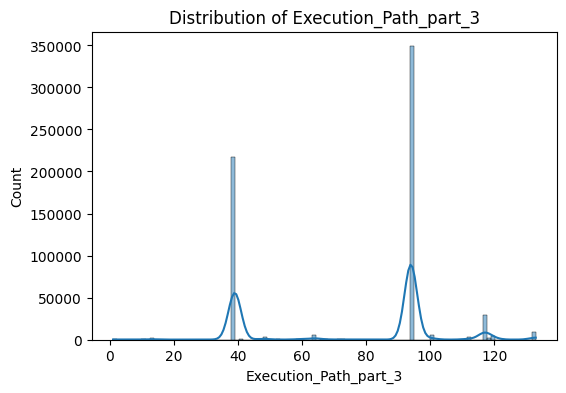

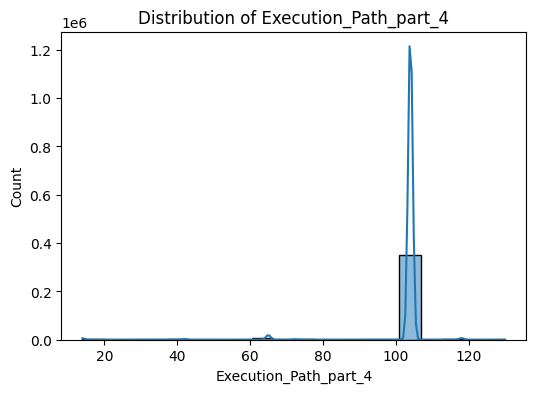

In [16]:
file_output = '/content/drive/MyDrive/hybrid_IDS/dataset/all/balanced_attack_E2.csv'
df = pd.read_csv(file_output)
total_rows = len(df)
nulls_part3 = df['Execution_Path_part_3'].isnull().sum()
nulls_part4 = df['Execution_Path_part_4'].isnull().sum()

print(f"Execution_Path_part_3 - Nulls: {nulls_part3} ({(nulls_part3/total_rows)*100:.2f}%)")
print(f"Execution_Path_part_4 - Nulls: {nulls_part4} ({(nulls_part4/total_rows)*100:.2f}%)")


import seaborn as sns
import matplotlib.pyplot as plt

# part 3
plt.figure(figsize=(6, 4))
sns.histplot(df['Execution_Path_part_3'].dropna(), kde=True)
plt.title("Distribution of Execution_Path_part_3")
plt.show()

# part 4
plt.figure(figsize=(6, 4))
sns.histplot(df['Execution_Path_part_4'].dropna(), kde=True)
plt.title("Distribution of Execution_Path_part_4")
plt.show()



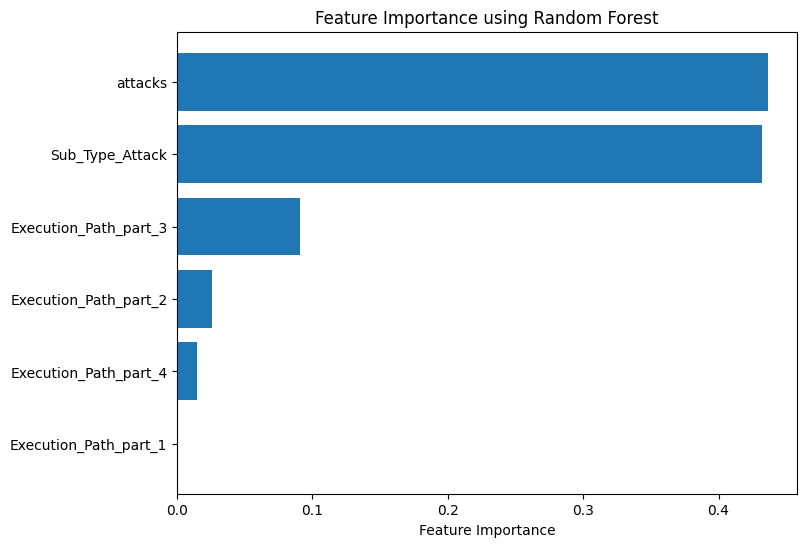

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


file_output = '/content/drive/MyDrive/hybrid_IDS/dataset/all/balanced_attack_E2.csv'
df = pd.read_csv(file_output)


# البيانات
X = df.drop('Label', axis=1)
y = df['Label']

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# تدريب النموذج
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# استخراج أهمية الميزات
importances = model.feature_importances_
features = X.columns

# رسم الأهمية
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance using Random Forest')
plt.gca().invert_yaxis()
plt.show()


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# تحميل البيانات
file_output = '/content/drive/MyDrive/hybrid_IDS/dataset/all/balanced_attack_E2.csv'
df = pd.read_csv(file_output)

# البيانات
X = df.drop('Label', axis=1)
y = df['Label']

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# تدريب النموذج
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# استخراج أهمية الميزات
importances = model.feature_importances_
features = X.columns

# تحديد العتبة للأهمية (مثلاً: حذف الميزات التي أهميتها أقل من 0.01)
threshold = 0.01
important_features = [features[i] for i in range(len(features)) if importances[i] > threshold]

# عرض الميزات التي يمكن الاحتفاظ بها
print("الميزات التي يمكن الاحتفاظ بها:", important_features)

# عرض الميزات التي يمكن حذفها
removable_features = [features[i] for i in range(len(features)) if importances[i] <= threshold]
print("الميزات التي يمكن حذفها:", removable_features)


الميزات التي يمكن الاحتفاظ بها: ['attacks', 'Sub_Type_Attack', 'Execution_Path_part_2', 'Execution_Path_part_3', 'Execution_Path_part_4']
الميزات التي يمكن حذفها: ['Execution_Path_part_1']


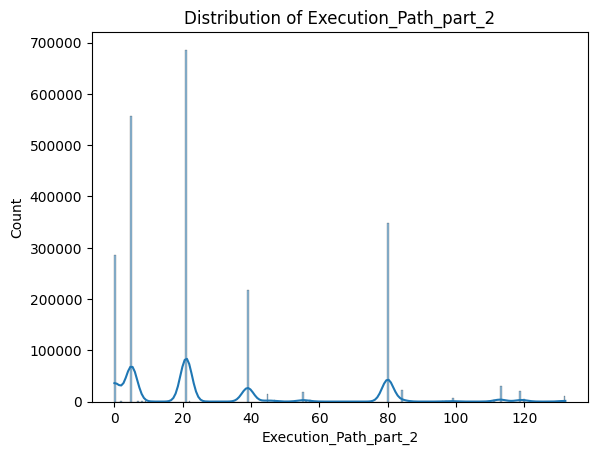

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['Execution_Path_part_2'].dropna(), kde=True)
plt.title("Distribution of Execution_Path_part_2")
plt.show()


In [ ]:

import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from tqdm import tqdm

def smart_chunk_impute_and_save(input_file, output_file, chunk_size=100000, knn_threshold=0.3, drop_threshold=0.8):
    """
    تعبئة القيم المفقودة للملفات الضخمة جداً بطريقة لا تسبب انفجار الرام.
    """

    reader = pd.read_csv(input_file, chunksize=chunk_size)

    first_chunk = True
    total_rows = 0

    for chunk in tqdm(reader, desc="Processing chunks", ncols=100):

        # الأعمدة المطلوبة
        cols_to_impute = ['Execution_Path_part_2', 'Execution_Path_part_3', 'Execution_Path_part_4']

        features = chunk[['attacks', 'Sub_Type_Attack', 'Label', 'Execution_Path_part_1'] + cols_to_impute]

        # التأكد من أن الأعمدة تحتوي على أرقام فقط
        features = features.apply(pd.to_numeric, errors='coerce')

        # حساب نسبة الفراغ
        missing_ratio = features.isna().mean()

        for col in cols_to_impute:
            if col not in chunk.columns:
                continue

            ratio = missing_ratio[col]

            if ratio > drop_threshold:
                # حذف العمود
                chunk.drop(columns=[col], inplace=True)

            elif ratio > knn_threshold:
                # استخدام Iterative Imputer
                temp_data = features[['attacks', 'Sub_Type_Attack', 'Label', 'Execution_Path_part_1', col]]
                imputer = IterativeImputer(max_iter=10, random_state=0)
                imputed_data = imputer.fit_transform(temp_data)
                chunk[col] = imputed_data[:, -1]

            else:
                # استخدام KNN Imputer
                temp_data = features[['attacks', 'Sub_Type_Attack', 'Label', 'Execution_Path_part_1', col]]
                imputer = KNNImputer(n_neighbors=5)
                imputed_data = imputer.fit_transform(temp_data)
                chunk[col] = imputed_data[:, -1]

        # حفظ chunk بالترتيب
        if first_chunk:
            chunk.to_csv(output_file, index=False, mode='w')
            first_chunk = False
        else:
            chunk.to_csv(output_file, index=False, header=False, mode='a')

        total_rows += len(chunk)

    print(f"\n✅ Done! Total saved rows: {total_rows}")


smart_chunk_impute_and_save(input_file='/content/drive/MyDrive/hybrid_IDS/dataset/all/final_del.csv',
                         output_file='/content/final_nan9.csv')

Processing chunks: 34it [03:26,  4.62s/it]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm  # Importing tqdm for the progress bar
import matplotlib.pyplot as plt

# Define a function to process each chunk and store the results
def process_chunk(chunk, rmse_results, best_n, best_rmse, scaler, model):
    # Fill missing values with the median
    chunk_filled = chunk.fillna(chunk.median())

    # Choose target and features columns
    target = 'Execution_Path_part_2'
    features = ['attacks', 'Sub_Type_Attack', 'Label', 'Execution_Path_part_1']

    # Prepare features and target
    X = chunk_filled[features]
    y = chunk_filled[target]

    # Standardize the features
    X = scaler.transform(X)

    # Make predictions on the chunk data
    y_pred = model.predict(X)

    # Create a DataFrame to store the results with the required columns
    selected_columns = chunk_filled[['attacks', 'Sub_Type_Attack', 'Label', 'Execution_Path_part_1', 'Execution_Path_part_2']].copy()
    selected_columns['n_neighbors'] = best_n
    selected_columns['RMSE'] = best_rmse
    selected_columns['y_pred'] = np.concatenate([y_pred, np.repeat(np.nan, len(chunk) - len(y_pred))])

    return selected_columns

# Initialize the list to store RMSE results
rmse_results = []

# Load the data in chunks
chunk_size = 100000  # Process in chunks of 2 million rows
chunks = pd.read_csv('/content/final_del_converted.csv', chunksize=chunk_size)

# Initialize the scaler and KNN model
scaler = StandardScaler()
best_knn = KNeighborsRegressor(n_neighbors=5)  # Initialize with any n_neighbors value for fitting

# Process the first chunk to train the model
first_chunk = next(chunks)
data_filled = first_chunk.fillna(first_chunk.median())  # Handle missing values
X_first = data_filled[['attacks', 'Sub_Type_Attack', 'Label', 'Execution_Path_part_1']]
y_first = data_filled['Execution_Path_part_2']
X_first = scaler.fit_transform(X_first)  # Fit scaler to first chunk
best_knn.fit(X_first, y_first)  # Fit model to the first chunk

# Loop through all chunks and process them
output_chunks = []
for chunk in tqdm(chunks, desc="Processing Chunks", ncols=100):
    # Process each chunk and get the result
    processed_chunk = process_chunk(chunk, rmse_results, best_n=5, best_rmse=0.0, scaler=scaler, model=best_knn)
    output_chunks.append(processed_chunk)

# Combine all processed chunks into a single DataFrame
final_output = pd.concat(output_chunks, ignore_index=True)

# Save the result into the same CSV file
final_output.to_csv('/content/drive/MyDrive/hybrid_IDS/host_E2_final_selected_output_with_predictions.csv', mode='w', index=False)

# Print the first few rows of the result
print(final_output.head())

# Optionally, plot the RMSE results for visualization
n_neighbors = [result[0] for result in rmse_results]
rmse_values = [result[1] for result in rmse_results]

plt.plot(n_neighbors, rmse_values, marker='o')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Neighbors')
plt.grid(True)
plt.show()


Processing Chunks: 1it [01:10, 70.96s/it]

In [ ]:
import pandas as pd
from tqdm import tqdm

# مسار الملف الأصلي
file = '/content/drive/MyDrive/hybrid_IDS/dataset/all/balanced_attack.csv'

# مسار الملف الجديد لحفظ النتائج بعد التحويل
#output_file = '/content/final_del_converted.csv'

# حجم الدفعة
chunk_size = 1000000

 # -1 لأن أول سطر هو رؤوس الأعمدة

# قراءة الملف على شكل دفعات مع tqdm
chunks = pd.read_csv(file, chunksize=chunk_size)

first_chunk = True

for chunk in tqdm(chunks,  desc="Processing Chunks"):
    print(chunk['Label'].value_counts())
    print(chunk.info())
    print(chunk.head())
    break


Processing Chunks: 0it [00:00, ?it/s]

Label
0    799726
1    200274
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   attacks                1000000 non-null  int64  
 1   Sub_Type_Attack        1000000 non-null  int64  
 2   Label                  1000000 non-null  int64  
 3   Execution_Path_part_1  1000000 non-null  int64  
 4   Execution_Path_part_2  991712 non-null   float64
 5   Execution_Path_part_3  127672 non-null   float64
 6   Execution_Path_part_4  65482 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 53.4 MB
None
   attacks  Sub_Type_Attack  Label  Execution_Path_part_1  \
0        7               52      0                     16   
1        7               52      0                     16   
2        7               52      0                     16   
3        2               29      1             

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file = '/content/final.csv'

# Load the data
chunk_size = 1000000  # عدد الصفوف بالدفعة
chunks = pd.read_csv(file, chunksize=chunk_size)
target_col = 'Label'

for chunk in chunks:
    # حساب مصفوفة الارتباط فقط بالنسبة للعمود المستهدف (Label)
    corr = chunk.corr(method='pearson')[target_col]
    #corr = chunk.corr(method='pearson')

    # عرض المصفوفة كجدول مرتب
    from IPython.display import display  # لو تعمل داخل jupyter أو colab
    display(corr)

    # عرض المصفوفة الحرارية (heatmap) مع اللون
    plt.figure(figsize=(10, 8), dpi=500)
    sns.heatmap(corr.T, annot=True, fmt=".2f", linewidth=.5, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Correlation Matrix with {target_col}")
    plt.show()

    break  # فقط أول دفعة

,Label
Unique_Identification,0.008000
System_Calls_Identifiers,0.000824
Event's_Unique_Identification,-0.044237
attacks,-0.988050
Sub_Type_Attack,-0.868515
Label,1.000000
hour,-0.055726
minute,0.020046
second,-0.030015
Execution_Path_part_0,-0.011172


IndexError: Inconsistent shape between the condition and the input (got (14, 1) and (14,))

<Figure size 5000x4000 with 0 Axes>

In [ ]:
!cp -r "/content/host logs" "/content/drive/MyDrive/hybrid_IDS/dataset/all/"

In [ ]:
!cp -r /content/files/final.csv /content/drive/MyDrive/hybrid_IDS/dataset/all/

In [ ]:
!rm -rf "/content/host logs"

In [ ]:
correlation_with_target = numeric_df.corr()[target_col].drop(target_col).sort_values(ascending=False)
correlation_with_target

,Label
path_part_4,0.259518
path_part_5,0.128456
path_part_2,0.122674
hour,0.010651
path_part_1,0.008840
Event's_Unique_Identification,0.005089
Unique_Identification,0.002967
second,0.001407
System_Calls_Identifiers,-0.001347
minute,-0.011156


In [ ]:
import pandas as pd


file = '/content/final_del_converted.csv'
# Load the data
chunk_size = 1000000  # عدد الصفوف بالدفعة
chunks = pd.read_csv(file, chunksize=chunk_size)
target_col = 'Label'
for chunk in chunks:
    #print(chunk.info())
    #print (chunk.head())
    correlation_with_target = chunk.corr()[target_col].drop(target_col).sort_values(ascending=False)
    #print(correlation_with_target)
    # Find the pearson correlations matrix
    #corr = chunk.corr(method = 'pearson')
    #print(corr)
    print(chunk['year'].value_counts())
    print(chunk['month'].value_counts())
    print(chunk['day'].value_counts())

    break  # فقط لعرض أول دفعة كمثال

year
2016    1000000
Name: count, dtype: int64
month
3    1000000
Name: count, dtype: int64
day
15    1000000
Name: count, dtype: int64


In [ ]:
import pandas as pd

file = '/content/final.csv'

# Load the data
chunk_size = 1000000  # عدد الصفوف بالدفعة
chunks = pd.read_csv(file, chunksize=chunk_size)
target_col = 'Label'

for chunk in chunks:
    # حساب مصفوفة الارتباط (Pearson)
    corr = chunk.corr(method='pearson')



    # عرض المصفوفة كجدول مرتب
    from IPython.display import display  # لو تعمل داخل jupyter أو colab
    display(corr)

    break  # فقط أول دفعة


,Unique_Identification,System_Calls_Identifiers,Event's_Unique_Identification,attacks,Sub_Type_Attack,Label,hour,minute,second,Execution_Path_part_0,Execution_Path_part_1,Execution_Path_part_2,Execution_Path_part_3,Execution_Path_part_4
Unique_Identification,1.000000,-0.356043,-0.226277,-0.006008,-0.007618,0.008000,-0.174586,-0.074778,0.031213,0.018835,0.835435,-0.180804,0.222207,0.424684
System_Calls_Identifiers,-0.356043,1.000000,-0.020682,-0.000216,0.000920,0.000824,-0.026462,0.002737,0.031236,-0.008794,-0.322491,0.162257,0.125857,0.156079
Event's_Unique_Identification,-0.226277,-0.020682,1.000000,0.047582,0.051690,-0.044237,0.871884,0.141818,0.032540,0.012869,-0.253982,-0.045786,-0.024917,-0.182539
attacks,-0.006008,-0.000216,0.047582,1.000000,0.852407,-0.988050,0.060558,-0.024268,0.030432,0.014902,-0.054266,-0.151590,0.319476,-0.676846
Sub_Type_Attack,-0.007618,0.000920,0.051690,0.852407,1.000000,-0.868515,0.059781,-0.015544,0.040103,0.019171,-0.032661,-0.071744,0.362865,-0.411986
Label,0.008000,0.000824,-0.044237,-0.988050,-0.868515,1.000000,-0.055726,0.020046,-0.030015,-0.011172,0.057090,0.152719,-0.324545,0.679153
hour,-0.174586,-0.026462,0.871884,0.060558,0.059781,-0.055726,1.000000,-0.331144,0.018938,0.005996,-0.210649,-0.030925,-0.042714,-0.235855
minute,-0.074778,0.002737,0.141818,-0.024268,-0.015544,0.020046,-0.331144,1.000000,0.006425,0.005650,-0.070744,-0.016027,0.037412,0.060329
second,0.031213,0.031236,0.032540,0.030432,0.040103,-0.030015,0.018938,0.006425,1.000000,0.084023,0.022400,-0.072040,-0.067048,0.333718
Execution_Path_part_0,0.018835,-0.008794,0.012869,0.014902,0.019171,-0.011172,0.005996,0.005650,0.084023,1.000000,0.020558,NaN,NaN,NaN


#network




In [ ]:
pip install scapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 14.3 MB/s eta 0:00:00


In [ ]:
import csv
import json
import os
import re
from tqdm import tqdm
from scapy.all import PcapReader

In [ ]:
class NetworkPreprocessing:
  def __init__(self):
    pass


  def extract_tcp_option(self, option, key):
    for opt in option:
      if opt[0] == key:
        return opt[1]
    return None


  def delete_data(self, file_path):
    df = pd.read_csv(file_path)
    df = df.loc[:, df.nunique() > 1]
    df.to_csv(file_path, index=False)
    return f"Columns containing only one value are deleted..."

  def convert_pcap_csv(self, pcap_file, csv_file):
    try:
      print("Countig packages...")
      with PcapReader(pcap_file) as count_reader:
        total_packets = sum(1 for _ in count_reader)
        print(f"Total number of packages: {total_packets}")

      print("Start converting to csv file...")
      with PcapReader(pcap_file) as packets:
        with open(csv_file, mode='w', newline="") as file:
          writer = csv.writer(file)
          writer.writerow([
              "Packet Number", "Ethernet DST", "Ethernet SRC", "Ethernet Type",
              "IP Version", "IP IHL", "IP TOS", "IP Length", "IP ID", "IP Flags",
              "IP Fragmentation", "IP TTL", "IP Proto", "IP Checksum",
              "IP Src", "IP Dst", "TCP Src Port", "TCP Dst Port", "TCP Seq",
              "TCP Ack", "TCP Data Offset", "TCP Reserved", "TCP Flags",
              "TCP Window", "TCP Checksum", "TCP Urgent Pointer", "TCP Options MSS",
              "TCP Options WScale", "TCP Options NOP","Hexdump"
          ])

          for i, packet in enumerate(tqdm(packets,total=total_packets, desc="Packet processing")):
            if packet.haslayer('Ethernet'):
              eth_dst = packet['Ethernet'].dst
              eth_src = packet['Ethernet'].src
              eth_type = packet['Ethernet'].type
            else:
              eth_dst = eth_src = eth_type = None

            if packet.haslayer('IP'):
              ip_version = packet['IP'].version
              ip_ihl = packet['IP'].ihl
              ip_tos = packet['IP'].tos
              ip_len = packet['IP'].len
              ip_id = packet['IP'].id
              ip_flags = packet['IP'].flags
              ip_frag = packet['IP'].frag
              ip_ttl = packet['IP'].ttl
              ip_proto = packet['IP'].proto
              ip_chksum = packet['IP'].chksum
              ip_src = packet['IP'].src
              ip_dst = packet['IP'].dst
            else:
              ip_version = ip_ihl = ip_tos = ip_len = ip_id = ip_flags = ip_frag = ip_ttl = ip_proto = ip_chksum = ip_src = ip_dst = None

            if packet.haslayer('TCP'):
              tcp_sport = packet['TCP'].sport
              tcp_dport = packet['TCP'].dport
              tcp_seq = packet['TCP'].seq
              tcp_ack = packet['TCP'].ack
              tcp_dataofs = packet['TCP'].dataofs
              tcp_reserved = packet['TCP'].reserved
              tcp_flags = packet['TCP'].flags
              tcp_window = packet['TCP'].window
              tcp_chksum = packet['TCP'].chksum
              tcp_urgptr = packet['TCP'].urgptr
              tcp_options = packet['TCP'].options

              tcp_mss = self.extract_tcp_option(tcp_options, 'MSS')
              tcp_wscale = self.extract_tcp_option(tcp_options, 'WScale')
              tcp_nop_count = self.extract_tcp_option(tcp_options, 'NOP')

            else:
              tcp_sport = tcp_dport = tcp_seq = tcp_ack = tcp_dataofs = tcp_reserved = tcp_flags = tcp_window = tcp_chksum = tcp_urgptr = tcp_mss = tcp_wscale = tcp_nop_count = None

            raw_data = packet.original.hex()
            writer.writerow([
                i + 1, eth_dst, eth_src, eth_type,
                  ip_version, ip_ihl, ip_tos, ip_len, ip_id, ip_flags,
                  ip_frag, ip_ttl, ip_proto, ip_chksum,
                  ip_src, ip_dst, tcp_sport, tcp_dport, tcp_seq,
                  tcp_ack, tcp_dataofs, tcp_reserved, tcp_flags,
                  tcp_window, tcp_chksum, tcp_urgptr, tcp_mss, tcp_wscale, tcp_nop_count,
                  raw_data
            ])

      return f"The file has been converted to csv successfully."
    except Exception as e:
      return f"An error occurred: {e}"

a = NetworkPreprocessing()
#a.convert_pcap_csv(pcap_file='/content/NGIDS/NGIDS-DS-v1/NGIDS.pcap',
#                   csv_file='/content/drive/MyDrive/hybrid_IDS/network.csv')
#a.delete_data(file_path='/content/drive/MyDrive/hybrid_IDS/network.csv')

'Columns containing only one value are deleted...'

In [ ]:
class PcapFileProcessing:
  def __init__(self) -> None:
    pass



  def delete_data(self, file_path):
    df = pd.read_csv(file_path)
    df = df.loc[:, df.nunique() > 1]
    df.to_csv(file_path, index=False)
    return f"Columns containing only one value are deleted..."


  def date_time_columns(self, file_path, csv_file):
    try:
        df = pd.read_csv(file_path, dtype=str)
        df.columns = df.columns.str.strip()
        if 'timestamp' not in df.columns:
            return "Error: The 'timestamp' column is missing from the file."

        df['timestamp'] = df['timestamp'].astype(str).str.strip()

        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', dayfirst=True)

        if df['timestamp'].isnull().all():
            return "All values in 'timestamp' are invalid and could not be converted."

        # Extract date and time
        df['date'] = df['timestamp'].dt.strftime('%d/%m/%Y')
        df['time'] = df['timestamp'].dt.strftime('%H:%M:%S')

        # Save the result
        df.to_csv(csv_file, index=False)

        return "Successfully converted 'timestamp' to 'date' and 'time'."

    except Exception as e:
        return f"An error occurred during conversion: {e}"





  def convert_log_csv(self, log_file, csv_file):
    try:
      print("Start converting to csv file...")
      with open(log_file, "r") as logfile:
        log_data = logfile.read()
      pattern = re.compile(
          r'(?P<timestamp>\d{2}/\d{2}/\d{4}-\d{2}:\d{2}:\d{2}\.\d+)\s+\[\*\*\]\s+\[(?P<sid>[^]]+)\]\s+(?P<signature>.*?)\s+\[\*\*\]\s+\[Classification:\s+(?P<classification>.*?)\]\s+\[Priority:\s+(?P<priority>\d+)\]\s+\{(?P<protocol>\w+)\}\s+(?P<src_ip>\d+\.\d+\.\d+\.\d+):(?P<src_port>\d+)\s+->\s+(?P<dst_ip>\d+\.\d+\.\d+\.\d+):(?P<dst_port>\d+)'
          )
      with open(csv_file, "w", newline="") as csvfile:
        fieldnames = ['timestamp', 'sid', 'signature', 'classification',
                      'priority', 'protocol','src_ip', 'src_port', 'dst_ip', 'dst_port']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for match in pattern.finditer(log_data):
          writer.writerow(match.groupdict())

      return f"The file has been converted to csv successfully."

    except Exception as e:
      return f"An error occurred: {e}"


  def convert_json_csv(self, json_file, csv_file):
    try:
      print("Start converting JSON to CSV...")
      with open(json_file, 'r') as f:
        data = [json.loads(line) for line in f if line.strip()]

      fieldnames = set()
      for row in data:
          fieldnames.update(row.keys())

      fieldnames = list(fieldnames)

      with open(csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(fieldnames)

        for row in data:
          writer.writerow(row.get(field, '') for field in fieldnames)

      return f"The file has been converted to csv successfully."

    except Exception as e:
      return f"An error occurred: {e}"



a = PcapFileProcessing()
#a.convert_log_csv( log_file="/content/drive/MyDrive/hybrid_IDS/fast.log",
#                  csv_file="/content/drive/MyDrive/hybrid_IDS/alerts.csv")

#a.convert_json_csv(json_file='/content/drive/MyDrive/hybrid_IDS/eve.json',
#                   csv_file='/content/drive/MyDrive/hybrid_IDS/eve.csv')

#a.delete_data( file_path='/content/drive/MyDrive/hybrid_IDS/eve.csv')
a.date_time_columns(file_path='/content/drive/MyDrive/hybrid_IDS/eve.csv',
                    csv_file='/content/drive/MyDrive/hybrid_IDS/dataset/eve.csv')

'تم تحويل timestamp بنجاح إلى date و time.'